<a href="https://colab.research.google.com/github/TECH-JUMAN/Linear-Regression/blob/main/finalmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SIGNAL SENTINEL AI-based signal classification system

deep learning-based system for detecting jamming in navigation signals. It simulates clean and jammed signals, converts them into spectrograms, and trains a Convolutional Neural Network (CNN) to classify them.

In [1]:

!pip install scipy matplotlib opencv-python-headless tensorflow --quiet

import os, shutil, random, math, time
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import cv2
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping



In [2]:
ROOT = "/content/navigation_signals"    # Colab path to dataset root
os.makedirs(ROOT, exist_ok=True)

N_CLEAN = 200
N_JAMMED = 200
SR = 2000            # sampling rate (Hz)
DURATION = 0.5       # seconds
IMG_H = 150
IMG_W = 150

SPLIT = {"train":0.70, "validation":0.15, "test":0.15}

# create dataset folders
for split in SPLIT:
    for cls in ["clean","jammed"]:
        os.makedirs(os.path.join(ROOT, split, cls), exist_ok=True)

In [3]:

def generate_bpsk_like(sr, duration, bitrate=10, carrier_freq=20, phase_noise=0.02):
    n = int(sr*duration)
    t = np.linspace(0,duration,n,endpoint=False)
    n_bits = max(1, int(duration*bitrate))
    bits = np.random.choice([1,-1], size=n_bits)
    samples_per_bit = int(math.ceil(n / n_bits))
    base = np.repeat(bits, samples_per_bit)[:n]
    carrier = np.cos(2*np.pi*carrier_freq*t + phase_noise*np.random.randn()*np.pi)
    sig = base * carrier
    sig *= (1 + 0.02*np.random.randn(n))
    return sig, t

def apply_jammer(sig, sr, strength_db=-6):
    n = sig.shape[0]
    noise = np.random.normal(scale=0.5, size=n)
    if random.random() < 0.6:
        jf = random.uniform(30,200)
        tone = 2.0 * np.sin(2*np.pi*jf*np.linspace(0,DURATION,n))
    else:
        f0 = random.uniform(40,100)
        f1 = random.uniform(150,400)
        tone = 2.0 * signal.chirp(np.linspace(0,DURATION,n), f0=f0, t1=DURATION, f1=f1, method='linear')
    factor = 10**(strength_db/20.0)
    jam = factor * tone + 0.4*noise
    return sig + jam

def save_spectrogram_image(sig, sr, out_path, img_h=IMG_H, img_w=IMG_W, cmap='inferno'):
    # compute spectrogram (magnitude)
    f, t_spec, Sxx = signal.spectrogram(sig, fs=sr, nperseg=128, noverlap=120, scaling='spectrum', mode='magnitude')
    Sxx_db = 20*np.log10(Sxx + 1e-10)
    # render compact figure
    fig = plt.figure(figsize=(1.5,1.5), dpi=100)
    ax = fig.add_subplot(111)
    ax.pcolormesh(t_spec, f, Sxx_db, shading='auto', cmap=cmap)
    ax.axis('off')
    plt.subplots_adjust(left=0,right=1,top=1,bottom=0)
    tmp = out_path + ".tmp.png"
    fig.savefig(tmp, bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    # read, resize, save final image
    img = cv2.imread(tmp)
    if img is None:
        img = np.zeros((img_h,img_w,3), dtype=np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_w, img_h), interpolation=cv2.INTER_AREA)
    cv2.imwrite(out_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    try:
        os.remove(tmp)
    except:
        pass


In [4]:
tmp_root = os.path.join(ROOT, "all")
for cls in ["clean","jammed"]:
    os.makedirs(os.path.join(tmp_root, cls), exist_ok=True)

def generate_and_save(n, label, out_dir):
    for i in range(n):
        sig, _ = generate_bpsk_like(SR, DURATION,
                                   bitrate=random.choice([8,10,12,15]),
                                   carrier_freq=random.choice([15,20,25,30]))
        if label == "jammed":
            strength = random.uniform(-12, 0)
            sig = apply_jammer(sig, SR, strength_db=strength)
        sig = sig / (np.max(np.abs(sig)) + 1e-9)
        fname = f"{label}_{i:03d}.png"
        out_path = os.path.join(out_dir, fname)
        save_spectrogram_image(sig, SR, out_path)

print("Generating clean signals...")
generate_and_save(N_CLEAN, "clean", os.path.join(tmp_root,"clean"))
print("Generating jammed signals...")
generate_and_save(N_JAMMED, "jammed", os.path.join(tmp_root,"jammed"))

# split into train/val/test
for cls in ["clean","jammed"]:
    files = sorted([os.path.join(tmp_root,cls,f) for f in os.listdir(os.path.join(tmp_root,cls)) if f.endswith(".png")])
    random.shuffle(files)
    n = len(files)
    n_train = int(n * SPLIT["train"])
    n_val = int(n * SPLIT["validation"])
    train_files = files[:n_train]
    val_files = files[n_train:n_train+n_val]
    test_files = files[n_train+n_val:]
    for f in train_files:
        shutil.copy(f, os.path.join(ROOT, "train", cls, os.path.basename(f)))
    for f in val_files:
        shutil.copy(f, os.path.join(ROOT, "validation", cls, os.path.basename(f)))
    for f in test_files:
        shutil.copy(f, os.path.join(ROOT, "test", cls, os.path.basename(f)))
    print(f"{cls}: total {n}, train {len(train_files)}, val {len(val_files)}, test {len(test_files)}")

shutil.rmtree(tmp_root, ignore_errors=True)
print("Dataset generation + split finished. Root folder:", ROOT)


Generating clean signals...
Generating jammed signals...
clean: total 200, train 140, val 30, test 30
jammed: total 200, train 140, val 30, test 30
Dataset generation + split finished. Root folder: /content/navigation_signals


# CNN

In [5]:
# TRAINING: uses the generated dataset in ROOT
img_height = IMG_H
img_width = IMG_W
batch_size = 32
n_epochs = 30

train_dir = os.path.join(ROOT, 'train')
validation_dir = os.path.join(ROOT, 'validation')
test_dir = os.path.join(ROOT, 'test')

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)
validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

# Simple CNN similar to reference (you can modify, add dropout, augmentation, etc.)
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_height,img_width,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

checkpoint_dir = './ckpt_nav'
os.makedirs(checkpoint_dir, exist_ok=True)
model_name = 'Nav_CNN_best.h5'
callbacks = [
    ModelCheckpoint(os.path.join(checkpoint_dir, model_name), monitor='val_loss', save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
]

history = model.fit(
    train_generator,
    epochs=n_epochs,
    validation_data=validation_generator,
    callbacks=callbacks
)

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator)
print('Test Acc:', test_acc)

# Save history
import pandas as pd
hist_df = pd.DataFrame(history.history)
hist_df.to_csv(os.path.join(checkpoint_dir, 'history.csv'), index=False)
print('Saved model+history to', checkpoint_dir)


Found 280 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5384 - loss: 0.7316

9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5452 - loss: 0.7300 - val_accuracy: 0.8167 - val_loss: 0.6045
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7761 - loss: 0.5596

9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.7760 - loss: 0.5528 - val_accuracy: 0.7833 - val_loss: 0.5011
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7723 - loss: 0.4760

9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.7751 - loss: 0.4709 - val_accuracy: 0.8667 - val_loss: 0.3226
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8978 - loss: 0.2726

9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8988 - loss: 0.2698 - val_accuracy: 0.8667 - val_loss: 0.2279
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.9088 - loss: 0.2159 - val_accuracy: 0.8833 - val_loss: 0.2797
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9311 - loss: 0.1782

9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.9316 - loss: 0.1749 - val_accuracy: 0.9500 - val_loss: 0.1345
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9592 - loss: 0.0915

9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9583 - loss: 0.0940 - val_accuracy: 1.0000 - val_loss: 0.0687
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9661 - loss: 0.0891 - val_accuracy: 0.9500 - val_loss: 0.0822
Epoch 9/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9677 - loss: 0.0738

9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9677 - loss: 0.0732 - val_accuracy: 0.9833 - val_loss: 0.0431
Epoch 10/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9585 - loss: 0.0731 - val_accuracy: 0.9333 - val_loss: 0.1076
Epoch 11/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9581 - loss: 0.0824 - val_accuracy: 0.9667 - val_loss: 0.0972
Epoch 12/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.9600 - loss: 0.1201 - val_accuracy: 1.0000 - val_loss: 0.1117
Epoch 13/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.9823 - loss: 0.0784 - val_accuracy: 0.9667 - val_loss: 0.0667
Epoch 14/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9594 - loss: 0.0708

9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.9591 - loss: 0.0702 - val_accuracy: 0.9833 - val_loss: 0.0376
Epoch 15/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9832 - loss: 0.0472

9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9831 - loss: 0.0477 - val_accuracy: 1.0000 - val_loss: 0.0186
Epoch 16/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 1.0000 - loss: 0.0252 - val_accuracy: 0.9667 - val_loss: 0.0454
Epoch 17/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9783 - loss: 0.0384

9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.9779 - loss: 0.0390 - val_accuracy: 1.0000 - val_loss: 0.0119
Epoch 18/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9957 - loss: 0.0219 - val_accuracy: 1.0000 - val_loss: 0.0195
Epoch 19/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0082

9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 1.0000 - loss: 0.0087 - val_accuracy: 1.0000 - val_loss: 0.0108
Epoch 20/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9965 - loss: 0.0113

9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.9965 - loss: 0.0116 - val_accuracy: 1.0000 - val_loss: 0.0080
Epoch 21/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 1.0000 - loss: 0.0073 - val_accuracy: 1.0000 - val_loss: 0.0104
Epoch 22/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9980 - loss: 0.0048

9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9979 - loss: 0.0049 - val_accuracy: 1.0000 - val_loss: 0.0071
Epoch 23/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0027

9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 1.0000 - loss: 0.0028 - val_accuracy: 1.0000 - val_loss: 0.0063
Epoch 24/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 1.0000 - loss: 0.0033 - val_accuracy: 1.0000 - val_loss: 0.0070
Epoch 25/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0013

9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 1.0000 - val_loss: 0.0029
Epoch 26/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 0.0034
Epoch 27/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 1.0000 - loss: 6.1547e-04 - val_accuracy: 1.0000 - val_loss: 0.0063
Epoch 28/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 1.0000 - loss: 7.5231e-04 - val_accuracy: 1.0000 - val_loss: 0.0073
Epoch 29/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 4.6574e-04

9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 1.0000 - loss: 4.9323e-04 - val_accuracy: 1.0000 - val_loss: 0.0022
Epoch 30/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 1.0000 - loss: 4.6456e-04 - val_accuracy: 1.0000 - val_loss: 0.0032
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step - accuracy: 1.0000 - loss: 0.0033
Test Acc: 1.0
Saved model+history to ./ckpt_nav


In [6]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

Configuring the Model for Training

In [7]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


Data Generators (Train / Validation / Test)

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen   = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/navigation_signals/train',
    target_size=(150,150),
    batch_size=32,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    '/content/navigation_signals/validation',
    target_size=(150,150),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    '/content/navigation_signals/test',
    target_size=(150,150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 280 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


Obtaining the Best Model Values (Checkpoints)

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os

ckpt_dir = '/content/checkpoints'
os.makedirs(ckpt_dir, exist_ok=True)

checkpoint_cb = ModelCheckpoint(
    filepath=os.path.join(ckpt_dir, 'best_model.h5'),
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)


Fitting the Model

In [12]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[checkpoint_cb, earlystop_cb]
)


Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9934 - loss: 0.0137
Epoch 1: val_loss did not improve from 0.00385
9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.9930 - loss: 0.0139 - val_accuracy: 1.0000 - val_loss: 0.0079
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9840 - loss: 0.0252
Epoch 2: val_loss did not improve from 0.00385
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9839 - loss: 0.0256 - val_accuracy: 0.9667 - val_loss: 0.0354
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9901 - loss: 0.0316
Epoch 3: val_loss did not improve from 0.00385
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9907 - loss: 0.0310 - val_accuracy: 1.0000 - val_loss: 0.0050
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0106
Epoch 4: val_loss improved from 0.00385 to 0.00170, saving model to /content/checkpoints/best_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 1.0000 - loss: 0.0101 - val_accuracy: 1.0000 - val_loss: 0.0017
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0035
Epoch 5: val_loss improved from 0.00170 to 0.00064, saving model to /content/checkpoints/best_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 1.0000 - val_loss: 6.3611e-04
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9996 - loss: 0.0021
Epoch 6: val_loss did not improve from 0.00064
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.9993 - loss: 0.0027 - val_accuracy: 1.0000 - val_loss: 7.4111e-04
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9890 - loss: 0.0602
Epoch 7: val_loss did not improve from 0.00064
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9883 - loss: 0.0615 - val_accuracy: 1.0000 - val_loss: 0.0105
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9948 - loss: 0.0225
Epoch 8: val_loss did not improve from 0.00064
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9946 - loss: 0.0225 - val_accuracy: 1.0000 - val_loss: 0.0151
Epoch 9/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9916 - loss: 0.0164
Epoch 9: val_loss did not improve from 0.00064
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s

Plotting Training Curves (Loss & Accuracy)

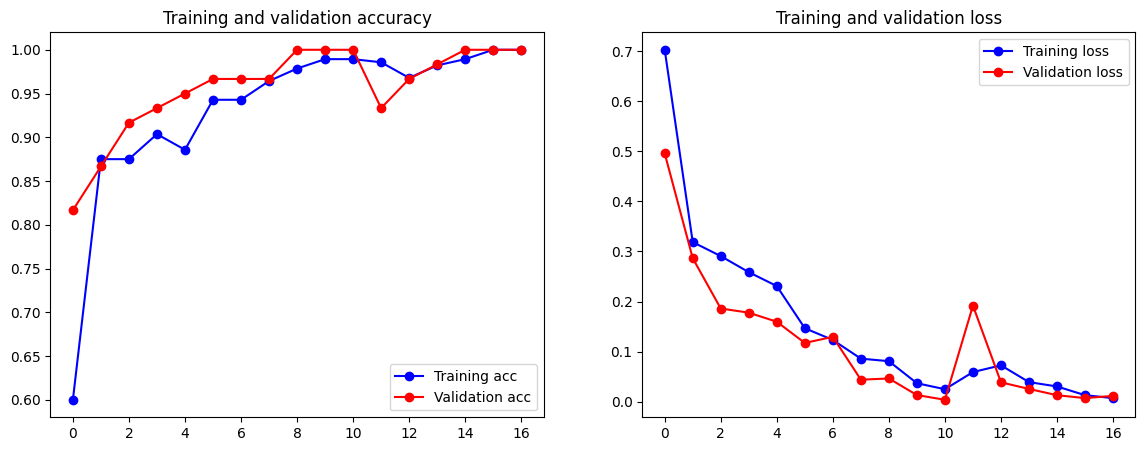

In [11]:
import matplotlib.pyplot as plt

acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']
epochs   = range(len(acc))

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(epochs, acc, 'bo-', label='Training acc')
plt.plot(epochs, val_acc, 'ro-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


Evaluating on the Test Set

In [13]:
test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step - accuracy: 0.9889 - loss: 0.0192
Test Accuracy: 0.9833333492279053
Test Loss: 0.027722012251615524


Load Best Model

In [14]:
from tensorflow.keras.models import load_model

best_model = load_model('/content/checkpoints/best_model.h5')


# Testing

In [15]:
import numpy as np
from tensorflow.keras.preprocessing import image

img_path = "/content/navigation_signals/test/jammed/jammed_005.png"

img = image.load_img(img_path, target_size=(150,150))
img_arr = image.img_to_array(img) / 255.0
img_arr = np.expand_dims(img_arr, axis=0)

pred = best_model.predict(img_arr)

if pred[0][0] >= 0.5:
    print("Prediction: JAMMED")
else:
    print("Prediction: CLEAN")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
Prediction: JAMMED


In [17]:
import numpy as np
from tensorflow.keras.preprocessing import image

img_path = "/content/navigation_signals/test/clean/clean_060.png"

img = image.load_img(img_path, target_size=(150,150))
img_arr = image.img_to_array(img) / 255.0
img_arr = np.expand_dims(img_arr, axis=0)

pred = best_model.predict(img_arr)

if pred[0][0] >= 0.5:
    print("Prediction: JAMMED")
else:
    print("Prediction: CLEAN")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Prediction: CLEAN


# Radar Signals

This model processes synthetic radar signals from **aircraft**, **drones**, and **vehicles** by converting them into spectrogram images. These spectrograms capture each target’s unique Doppler and micro-Doppler patterns. A **convolutional neural network **(CNN) then learns these patterns and accurately classifies the type of target based on its radar signature.
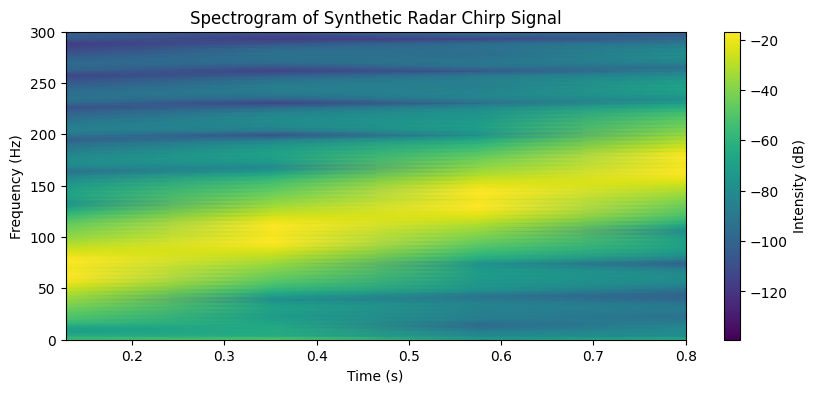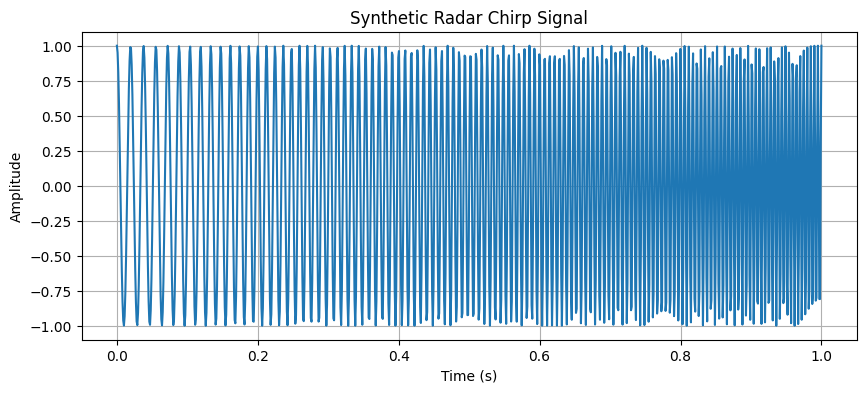


In [1]:
!pip install -q matplotlib opencv-python-headless scipy tensorflow scikit-learn

import os, shutil, random
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import cv2
import itertools

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


# Folder Setup

In [2]:
ROOT = "/content/radar_signals"
os.makedirs(ROOT, exist_ok=True)

CLASSES = ["aircraft", "drone", "vehicle"]
N_PER_CLASS = 500     # medium dataset
SR = 2000             # sample rate
T = 0.5               # duration
IMG_H, IMG_W = 150, 150

SPLIT = {"train":0.70, "validation":0.15, "test":0.15}

# Create folders
for split in SPLIT:
    for cls in CLASSES:
        os.makedirs(os.path.join(ROOT, split, cls), exist_ok=True)


In [3]:

def gen_aircraft(sr, T):
    n = int(sr*T)
    t = np.linspace(0, T, n, endpoint=False)

    doppler = random.uniform(150, 300)
    carrier = np.cos(2*np.pi*doppler*t)

    blade_freqs = [random.uniform(600, 1200)]
    micro = sum(0.05*np.sin(2*np.pi*f*t) for f in blade_freqs)

    jitter = 0.02*np.sin(2*np.pi*2*t)

    sig = carrier + micro + jitter + 0.01*np.random.randn(n)
    return sig
def gen_drone(sr, T):
    n = int(sr*T)
    t = np.linspace(0, T, n, endpoint=False)

    doppler = random.uniform(40, 120)
    carrier = np.cos(2*np.pi*doppler*t)

    blade = random.uniform(80, 150)
    harmonics = [blade*i for i in range(1, 5)]
    micro = sum(0.15*np.sin(2*np.pi*f*t) for f in harmonics)

    wobble = 0.05*np.sin(2*np.pi*random.uniform(2,5)*t)

    sig = carrier + micro + wobble + 0.02*np.random.randn(n)
    return sig
def gen_vehicle(sr, T):
    n = int(sr*T)
    t = np.linspace(0, T, n, endpoint=False)

    doppler = random.uniform(5, 25)
    carrier = np.cos(2*np.pi*doppler*t)

    engine = [20, 40, 80, 120]
    vib = sum(0.08*np.sin(2*np.pi*f*t) for f in engine)

    clutter = 0.2 * np.sin(2*np.pi*random.uniform(0.5,2)*t)

    sig = carrier + vib + clutter + 0.01*np.random.randn(n)
    return sig


In [4]:
def save_spectrogram(sig, sr, out_path):
    f, t_spec, Sxx = signal.spectrogram(
        sig, fs=sr, nperseg=256, noverlap=200,
        scaling='spectrum', mode='magnitude'
    )

    Sxx_db = 20*np.log10(Sxx + 1e-10)
    Sxx_db = np.clip(Sxx_db, -90, -20)

    fig = plt.figure(figsize=(1.6,1.6), dpi=100)
    ax = fig.add_subplot(111)
    ax.pcolormesh(t_spec, f, Sxx_db, shading='auto', cmap='inferno')
    ax.axis('off')
    plt.subplots_adjust(left=0,right=1,top=1,bottom=0)

    tmp = out_path + ".tmp.png"
    fig.savefig(tmp, bbox_inches='tight', pad_inches=0)
    plt.close(fig)

    img = cv2.imread(tmp)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_W, IMG_H))
    cv2.imwrite(out_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    os.remove(tmp)


In [5]:
tmp_root = os.path.join(ROOT, "all")
for cls in CLASSES:
    os.makedirs(os.path.join(tmp_root, cls), exist_ok=True)

generators = {
    "aircraft": gen_aircraft,
    "drone": gen_drone,
    "vehicle": gen_vehicle
}

# Generate data
for cls in CLASSES:
    print("Generating", cls)
    for i in range(N_PER_CLASS):
        sig = generators[cls](SR, T)
        sig = sig / (np.max(np.abs(sig)) + 1e-9)
        fname = f"{cls}_{i:04d}.png"
        save_spectrogram(sig, SR, os.path.join(tmp_root, cls, fname))

# Split
for cls in CLASSES:
    files = os.listdir(os.path.join(tmp_root, cls))
    random.shuffle(files)
    n = len(files)
    n_train = int(n*SPLIT["train"])
    n_val   = int(n*SPLIT["validation"])

    for f in files[:n_train]:
        shutil.copy(os.path.join(tmp_root,cls,f), os.path.join(ROOT,"train",cls,f))
    for f in files[n_train:n_train+n_val]:
        shutil.copy(os.path.join(tmp_root,cls,f), os.path.join(ROOT,"validation",cls,f))
    for f in files[n_train+n_val:]:
        shutil.copy(os.path.join(tmp_root,cls,f), os.path.join(ROOT,"test",cls,f))

shutil.rmtree(tmp_root)



Generating aircraft
Generating drone
Generating vehicle


# Data Generation

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

train_gen = train_datagen.flow_from_directory(
    os.path.join(ROOT,"train"),
    target_size=(IMG_H,IMG_W),
    batch_size=batch_size,
    class_mode="categorical"
)

val_gen = val_datagen.flow_from_directory(
    os.path.join(ROOT,"validation"),
    target_size=(IMG_H,IMG_W),
    batch_size=batch_size,
    class_mode="categorical"
)

test_gen = test_datagen.flow_from_directory(
    os.path.join(ROOT,"test"),
    target_size=(IMG_H,IMG_W),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)


Found 1050 images belonging to 3 classes.
Found 225 images belonging to 3 classes.
Found 225 images belonging to 3 classes.


# CNN Model

In [9]:
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Input

model = models.Sequential([
    Input(shape=(IMG_H, IMG_W, 3)),  # Fixed: Use Input layer instead of input_shape in Conv2D
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),

    layers.Flatten(),  # Fixed: Corrected typo from 'Flation' to 'Flatten'
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,812,995 (25.99 MB)

 Trainable params: 6,812,995 (25.99 MB)

 Non-trainable params: 0 (0.00 B)

# Train the Model

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Use recommended .keras format (lowercase)
ckpt = ModelCheckpoint("best_radar_model.keras",  # Fixed extension
                       monitor="val_loss",
                       save_best_only=True,
                       verbose=1)

early = EarlyStopping(monitor="val_loss",
                      patience=6,
                      restore_best_weights=True)

history = model.fit(
    train_gen,
    epochs=30,
    validation_data=val_gen,
    callbacks=[ckpt, early]
)

Epoch 1/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9816 - loss: 0.1957
Epoch 1: val_loss improved from inf to 0.00090, saving model to best_radar_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.9816 - loss: 0.1933 - val_accuracy: 1.0000 - val_loss: 9.0195e-04
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9907 - loss: 0.0513
Epoch 2: val_loss improved from 0.00090 to 0.00013, saving model to best_radar_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.9907 - loss: 0.0509 - val_accuracy: 1.0000 - val_loss: 1.3362e-04
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 0.0019
Epoch 3: val_loss improved from 0.00013 to 0.00000, saving model to best_radar_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 3.1418e-07
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 5.9883e-06
Epoch 4: val_loss improved from 0.0000

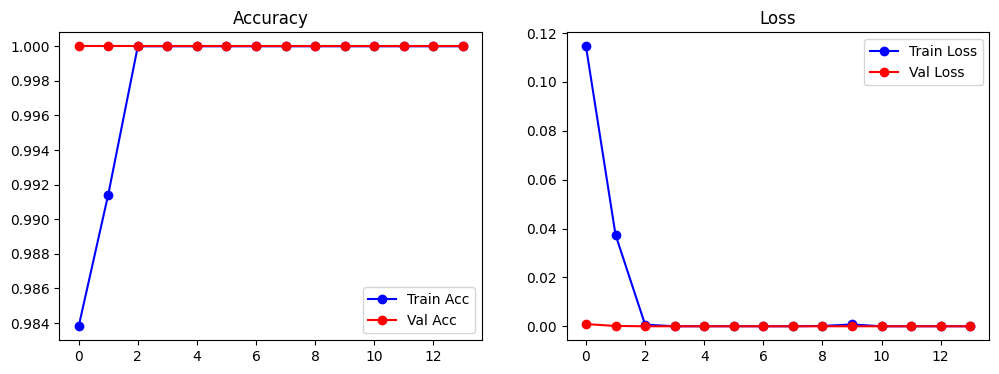

In [13]:
acc = history.history['accuracy']; val_acc = history.history['val_accuracy']
loss = history.history['loss']; val_loss = history.history['val_loss']
E = range(len(acc))

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(E, acc,'bo-',label='Train Acc')
plt.plot(E, val_acc,'ro-',label='Val Acc')
plt.legend(); plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(E, loss,'bo-',label='Train Loss')
plt.plot(E, val_loss,'ro-',label='Val Loss')
plt.legend(); plt.title("Loss")
plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 510ms/step
Confusion Matrix:
 [[75  0  0]
 [ 0 75  0]
 [ 0  0 75]]

Classification Report:

              precision    recall  f1-score   support

    aircraft       1.00      1.00      1.00        75
       drone       1.00      1.00      1.00        75
     vehicle       1.00      1.00      1.00        75

    accuracy                           1.00       225
   macro avg       1.00      1.00      1.00       225
weighted avg       1.00      1.00      1.00       225



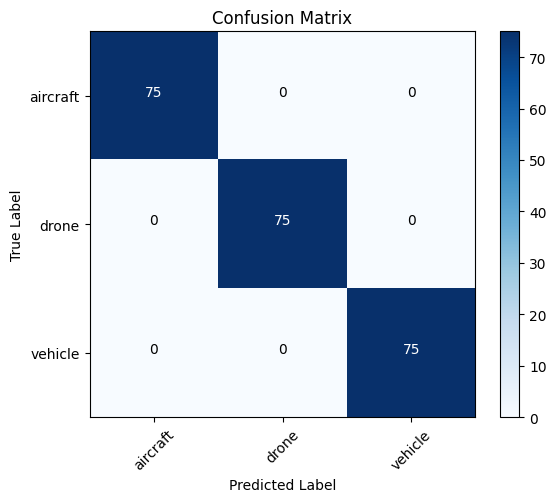

In [15]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import itertools

# Predict on test set
y_prob = model.predict(test_gen)
y_pred = np.argmax(y_prob, axis=1)
y_true = test_gen.classes
labels = CLASSES

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=labels))

# ---- Plot Confusion Matrix ----
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Predicted Class: aircraft
Class Probabilities: {'aircraft': np.float32(1.0), 'drone': np.float32(0.0), 'vehicle': np.float32(0.0)}


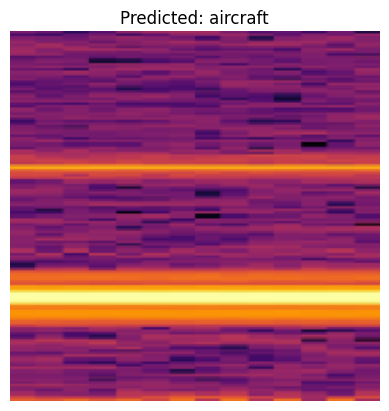

In [16]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Choose any test image
img_path = test_gen.filepaths[0]   # or replace with your own path

# Load image
img = image.load_img(img_path, target_size=(IMG_H, IMG_W))
x = image.img_to_array(img)
x = x / 255.0
x = np.expand_dims(x, axis=0)

# Predict
pred = model.predict(x)[0]
pred_class = CLASSES[np.argmax(pred)]

print("Predicted Class:", pred_class)
print("Class Probabilities:", dict(zip(CLASSES, pred.round(3))))

# Show image
plt.imshow(img)
plt.title(f"Predicted: {pred_class}")
plt.axis('off')
plt.show()